In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
df= pd.read_csv("C:\\Users\\shiva\\Downloads\\1566814021_lesson8timeseriesmodeling\\Lesson 8-Time Series Modeling\\monthly-beer-production-in-austr.csv")
df.head(10)

,Month,Monthly beer production in Australia
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
5,1956-06,64.8
6,1956-07,70.1
7,1956-08,77.3
8,1956-09,79.5
9,1956-10,100.6


• Check for the stationarity of your data using Rolling Statistics and Dickey-Fuller test.

• If stationarity is present, remove it using differencing in Python.

In [4]:
df['Month'].head()

0    1956-01
1    1956-02
2    1956-03
3    1956-04
4    1956-05
Name: Month, dtype: object

In [5]:
df.isnull().sum()

Month                                   0
Monthly beer production in Australia    0
dtype: int64

In [6]:
df['Month']= df['Month'].apply(lambda x: dt(int(x[:4]),int(x[5:]),15))
df= df.set_index('Month')
df.head()

,Monthly beer production in Australia
Month,
1956-01-15,93.2
1956-02-15,96.0
1956-03-15,95.2
1956-04-15,77.1
1956-05-15,70.9


In [7]:
from statsmodels.tsa.stattools import adfuller

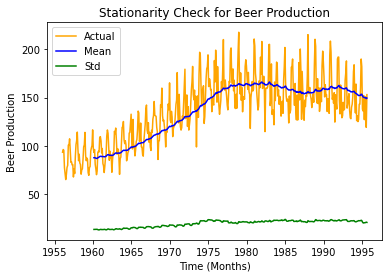

The test statistic is -2.283
The p-value is 0.178
The respective signifiance levels are:
1%    -3.444709
5%    -2.867871
10%   -2.570142
dtype: float64


In [8]:
# checking for stationarity using rolling statistics
def stationarity_test(time_series_data):
    
    # obtaining mean and standard deviation values 
    rolling_mean = time_series_data.rolling(window=50).mean()
    rolling_std = time_series_data.rolling(window=50).std()
    
    # plotting statistics
    plt.plot(time_series_data,color='orange',label='Actual Data')
    plt.plot(rolling_mean,color='blue',label='Mean')
    plt.plot(rolling_std,color='green',label='Standard Deviation')
    plt.legend(['Actual','Mean','Std'])
    
    plt.title('Stationarity Check for Beer Production')
    plt.xlabel('Time (Months)')
    plt.ylabel('Beer Production')
    plt.show()
    
    # Peforming Dickey-Fuller Test
    adfuller_test = adfuller(time_series_data,autolag = 'AIC')
    print('The test statistic is %.3f' % adfuller_test[0])
    print('The p-value is %.3f' %adfuller_test[1])
    print('The respective signifiance levels are:')
    print(pd.Series(adfuller_test[4]))

stationarity_test(df)

From our Augmented Dickey-Fuller test, we notice that the p-value does not satisfy any of the significance levels (1%, 5% and 10%). We go ahead and stationarize our data using the differencing method.

            Monthly beer production in Australia
Month                                           
1956-01-15                              4.534748
1956-02-15                              4.564348
1956-03-15                              4.555980
1956-04-15                              4.345103
1956-05-15                              4.261270


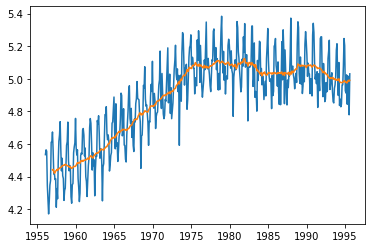

In [9]:
# apply log transformation
df_log = np.log(df)
print(df_log.head())
movingAverage = df_log.rolling(window=12).mean()
movingStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(movingAverage);

            Monthly beer production in Australia
Month                                           
1956-12-15                              0.231830
1957-01-15                              0.118994
1957-02-15                             -0.015558
1957-03-15                              0.001590
1957-04-15                             -0.041908


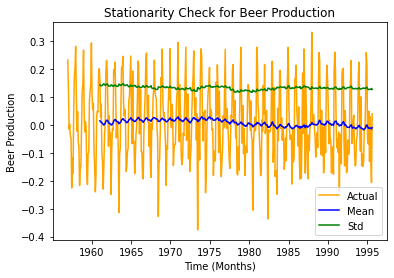

The test statistic is -3.433
The p-value is 0.010
The respective signifiance levels are:
1%    -3.444933
5%    -2.867970
10%   -2.570195
dtype: float64


In [10]:
# perform differencing using moving average
df_log_diff = df_log - movingAverage

# drop all NaN rows
df_log_diff.dropna(axis = 0, inplace = True)
print(df_log_diff.head())

# perform stationarity check again
stationarity_test(df_log_diff)

Now our time series model is stationary. All the significance levels have been satisfied by our p-value.

Objective:
• Perform ARIMA modeling in Python after obtaining ACF and PACF plots

In [17]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

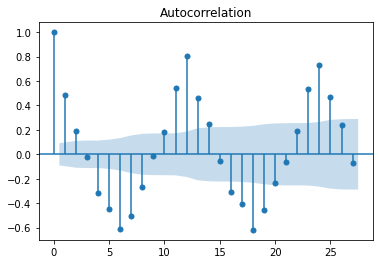

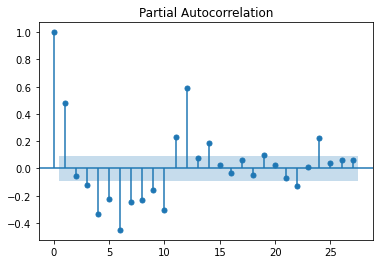

In [18]:
# perform time series forecasting
plot_acf(df_log_diff)
plt.show()

plot_pacf(df_log_diff)
plt.show()

C:\Users\shiva\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\shiva\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


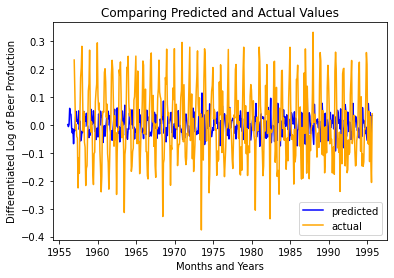

In [20]:
# creating ARIMA model
arima_model = ARIMA(df_log, order = (0,1,1))
fitted_arima_model = arima_model.fit(disp=-1)

# comparing actual and predicted values in a plot
plt.plot(fitted_arima_model.fittedvalues, color = 'blue')
plt.plot(df_log_diff,color = 'orange')
plt.legend(['predicted','actual'])
plt.title('Comparing Predicted and Actual Values')
plt.xlabel('Months and Years')
plt.ylabel('Differentiated Log of Beer Profuction')
plt.show()

# storing fitted arima model in variable
fitted_model_values = pd.Series(fitted_arima_model.fittedvalues, copy=True)

# plt.plot(fitted_model_values)
# plt.plot(df_ts_log_diff)

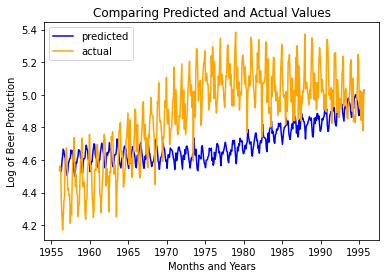

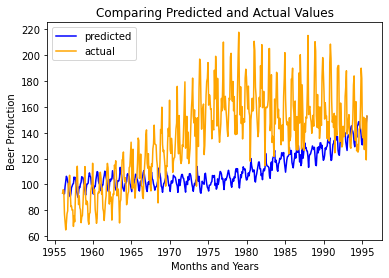

In [21]:
# undo differencing
fitted_model_values_cumsum = fitted_model_values.cumsum()
df_base_number = pd.Series(df_log.iloc[0].values[0],index=fitted_model_values_cumsum.index)
updated_fitted_model_values = df_base_number.add(fitted_model_values_cumsum,fill_value = 0)

# comparing actual and predicted values in a plot
plt.plot(updated_fitted_model_values,color = 'blue')
plt.plot(df_log,color = 'orange')
plt.legend(['predicted','actual'])
plt.title('Comparing Predicted and Actual Values')
plt.xlabel('Months and Years')
plt.ylabel('Log of Beer Profuction')
plt.show()

# undoing log transformation
predicted_values = np.exp(updated_fitted_model_values)

# comparing actual and predicted values in a plot
plt.plot(predicted_values,color = 'blue')
plt.plot(df,color = 'orange')
plt.legend(['predicted','actual'])
plt.title('Comparing Predicted and Actual Values')
plt.xlabel('Months and Years')
plt.ylabel('Beer Profuction')
plt.show()

<AxesSubplot:xlabel='Month'>

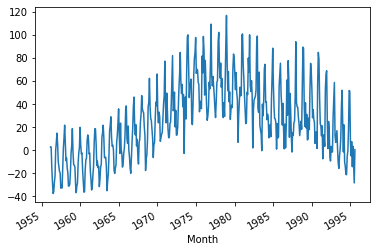

In [22]:
# checking for forecast error
actual_values = df.values.copy()[1:]
predicted_values_copy = np.reshape(predicted_values.copy().values,[475,1])
error = actual_values - predicted_values_copy
error = pd.Series(error.ravel(),index=fitted_model_values.index)
error.plot()